# Skin Cancer Classification

## LIBRARIES

In [199]:
import tensorflow as tf
import keras.backend as K
from tensorflow import keras    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomCrop, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications import efficientnet_v2 , EfficientNetB3
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os, cv2

# The next line for using GPU through CUDA core for computitation
# Comment all lines if you don't have NVIDIA CUDA GPU 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## DATASET
**You can find the DATA [HERE](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)**

**Dataset overview:**
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes.

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:
- Actinic keratoses and intraepithelial carcinoma Bowen's disease **(akiec)**
- basal cell carcinoma **(bcc)**
- benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, **bkl**)
- dermatofibroma **(df)**
- melanoma **(mel)**
- melanocytic nevi **(nv)**
- vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, **vasc**).

More than 50% of lesions are confirmed through histopathology **(histo)**, the ground truth for the rest of the cases is either follow-up examination **(follow_up)**, expert consensus **(consensus)**, or confirmation by in-vivo confocal microscopy **(confocal)**. The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [30]:
# Read Images Data into DataFrame fro, Model Training
ImagesData = pd.read_csv('Skin-Cancer-MNIST-HAM10000/hmnist_28_28_RGB.csv')

In [31]:
# Split Training features and the Label (x,y)
y = ImagesData['label']
x = ImagesData.drop(columns = ['label'])

In [32]:
# Read Images Metadata file into DataFrame 
MetaData = pd.read_csv('skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
MetaData.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [33]:
# Define Calsses mentioned in Data overview and located in Metadat file dx column as dict with key as encoding alphaptically ordered.
classes = {4: ('nv', 'melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'),
           1: ('bcc' , 'basal cell carcinoma'),
           5: ('vasc', 'pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [179]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params,)

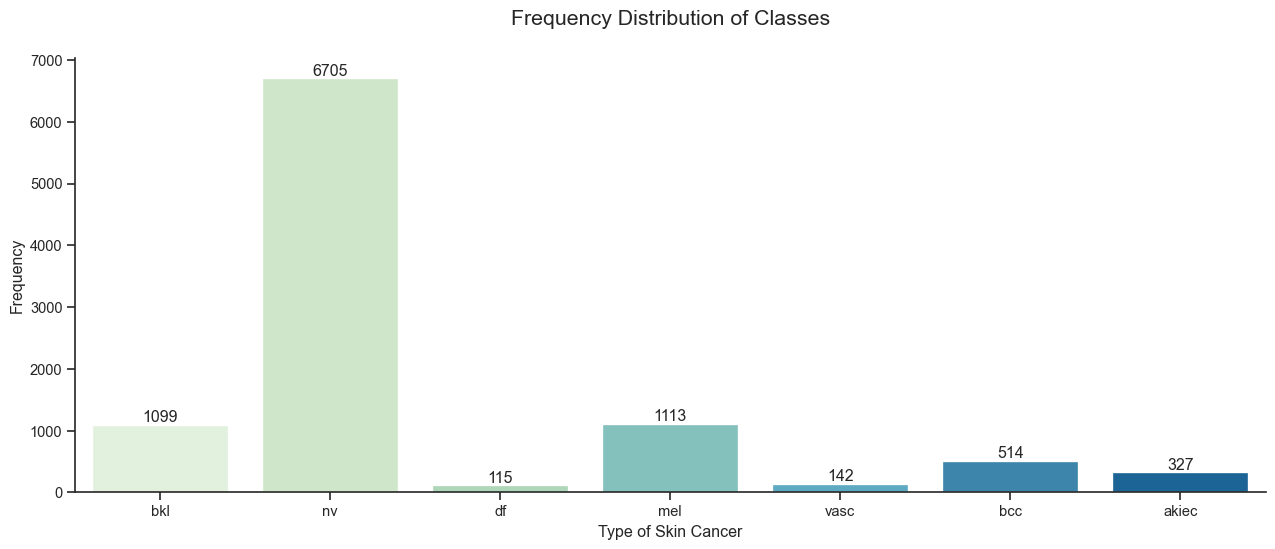

In [178]:
# polt Frequency distribution of the data
plt.figure(figsize=(16,6),dpi=96)
ax = sns.countplot(x = 'dx', data = MetaData, palette="GnBu")
ax.bar_label(ax.containers[0])
ax.set_title('Frequency Distribution of Classes', size=16 ,y=1.0, pad=25)
plt.xlabel('Type of Skin Cancer', size=12)
plt.ylabel('Frequency', size=12)
#plt.title('Frequency Distribution of Classes', size=16)
plt.show()

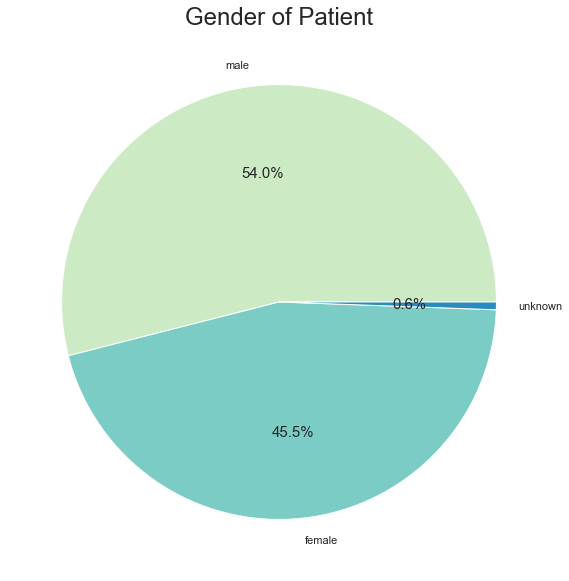

In [180]:
# Plot the total percentage of gender exist in the data
plt.rcParams['font.size'] = 15.0
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(MetaData['sex'].value_counts(), labels = MetaData['sex'].value_counts().index, autopct="%.1f%%", colors=sns.color_palette("GnBu",3))
plt.title('Gender of Patient', size=24)
plt.show()

<Figure size 1152x960 with 0 Axes>

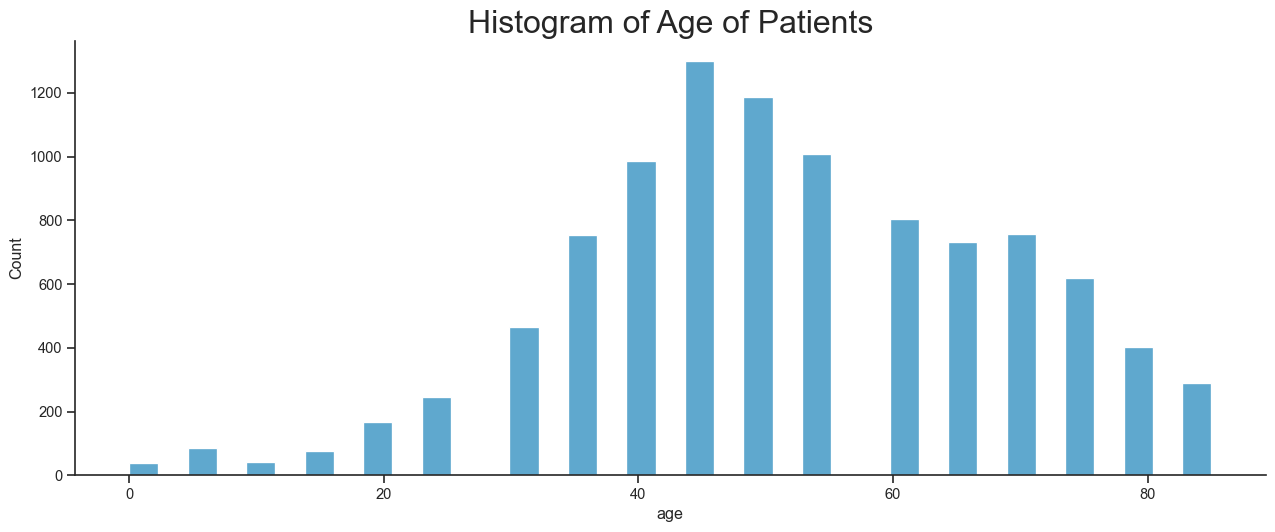

In [181]:
# Plot the distribution of data over the age of patient
plt.figure(figsize=(12,10),dpi=96)
bar, ax = plt.subplots(figsize=(16,6),dpi=96)
sns.histplot(MetaData['age'], color=sns.color_palette('GnBu',3)[2])
plt.title('Histogram of Age of Patients', size=24)
plt.show()

## CUSTOM MODEL

In [37]:
# over-sample the minority classes by picking samples at random with replacement.
OverSampler = RandomOverSampler()
x, y  = OverSampler.fit_resample(x, y)

In [38]:
print(np.array(x).shape)

(46935, 2352)


In [39]:
# reshape 
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [40]:
# Data Normalization
x = (x-np.mean(x)) / np.std(x)

# Train- Test Split
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

### Create Model

In [41]:
# Initiate Keras Sequential Model
model = Sequential()

model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten()) # Flatten feature-map or Extracted weights to 1D tensor.
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax', name="Output")) # Dense with 7 units (NUMBER OF CLASSES) and Softmax Activation for Categorical classification

# Print The model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [42]:
# custom callback function to save the weights weverytime the validation accuracy increases
callback = tf.keras.callbacks.ModelCheckpoint(filepath='HAM_ModelV2.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [43]:
# Compile Model with Sparse categorical crossentropy (0,1,2,...), Adam Optimizer, and look for the Accuracy metric.
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

### Training

In [44]:
# Fit training and validation data to the model for training process 
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 24,
                    callbacks=[callback])

Epoch 1/24
235/235 [==============================] - ETA: 0s - loss: 1.2571 - accuracy: 0.5095
Epoch 1: saving model to HAM_ModelV2.h5
235/235 [==============================] - 4s 13ms/step - loss: 1.2571 - accuracy: 0.5095 - val_loss: 0.9296 - val_accuracy: 0.6543
Epoch 2/24
230/235 [============================>.] - ETA: 0s - loss: 0.7539 - accuracy: 0.7196
Epoch 2: saving model to HAM_ModelV2.h5
235/235 [==============================] - 2s 11ms/step - loss: 0.7513 - accuracy: 0.7204 - val_loss: 0.5977 - val_accuracy: 0.7820
Epoch 3/24
231/235 [============================>.] - ETA: 0s - loss: 0.5152 - accuracy: 0.8136
Epoch 3: saving model to HAM_ModelV2.h5
235/235 [==============================] - 3s 11ms/step - loss: 0.5142 - accuracy: 0.8141 - val_loss: 0.4157 - val_accuracy: 0.8538
Epoch 4/24
232/235 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.8716
Epoch 4: saving model to HAM_ModelV2.h5
235/235 [==============================] - 3s 14ms/step - lo

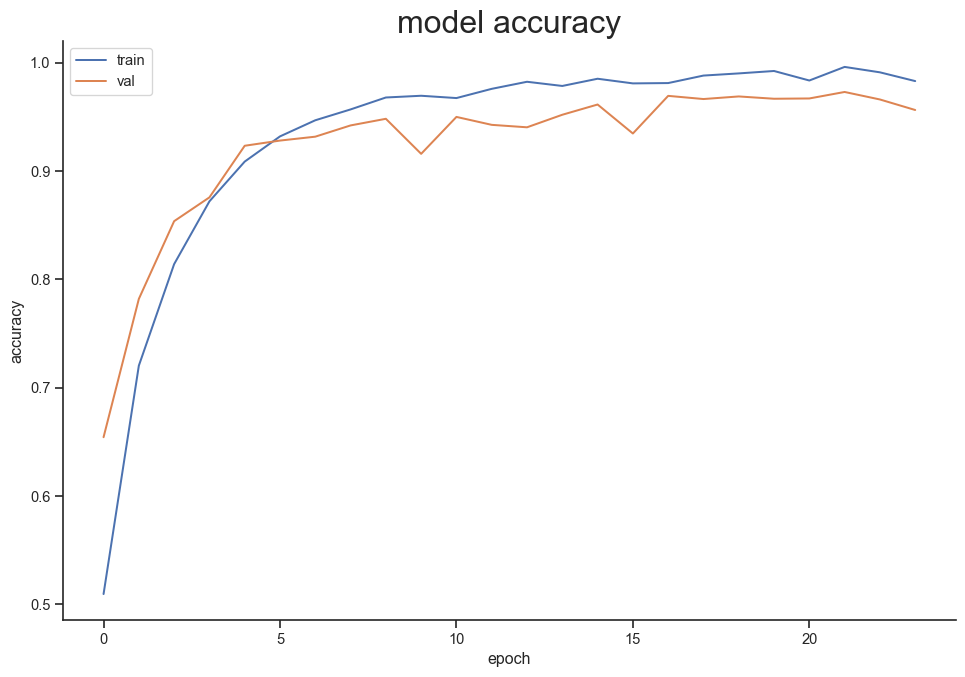

In [182]:
# Plot Model Training and Validation Accuracy during learning period
plt.figure(figsize=(12,8),dpi=96)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy', size=24)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

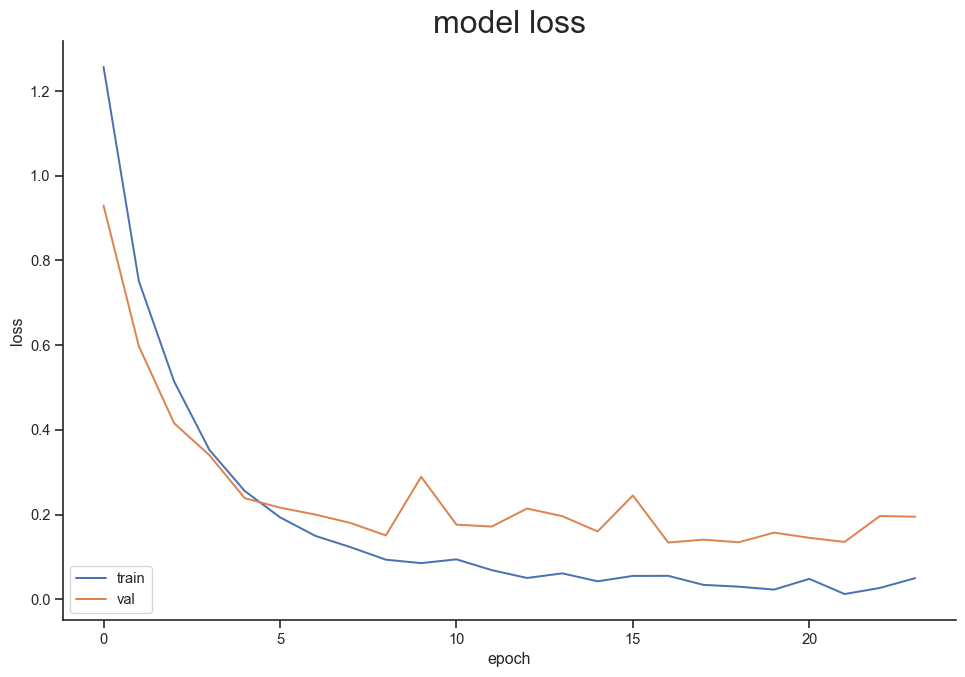

In [188]:
# # Plot Model Training and Validation Loss during learning period
plt.figure(figsize=(12,8),dpi=96)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', size=24)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

### Testing

In [47]:
# Evauate the model with the test data
loss, acc = model.evaluate(X_test, Y_test, verbose=1)

294/294 [==============================] - 1s 3ms/step - loss: 0.1996 - accuracy: 0.9509


In [22]:
# load saved Model
model = keras.models.load_model('HAM_Model.h5')

In [48]:
# Evalue Again after saving 
loss, acc = model.evaluate(X_test, Y_test, verbose=1)

294/294 [==============================] - 1s 3ms/step - loss: 0.1996 - accuracy: 0.9509


In [49]:
# prediction on test data 
Y_pred = model.predict(X_test)

294/294 [==============================] - 1s 2ms/step


In [50]:
# Returns the indices of the maximum values along an axis.
y_pred = np.argmax(Y_pred, axis=1)

In [51]:
# Generate Confusion Matrix
cf_matrix = confusion_matrix(Y_test, y_pred)

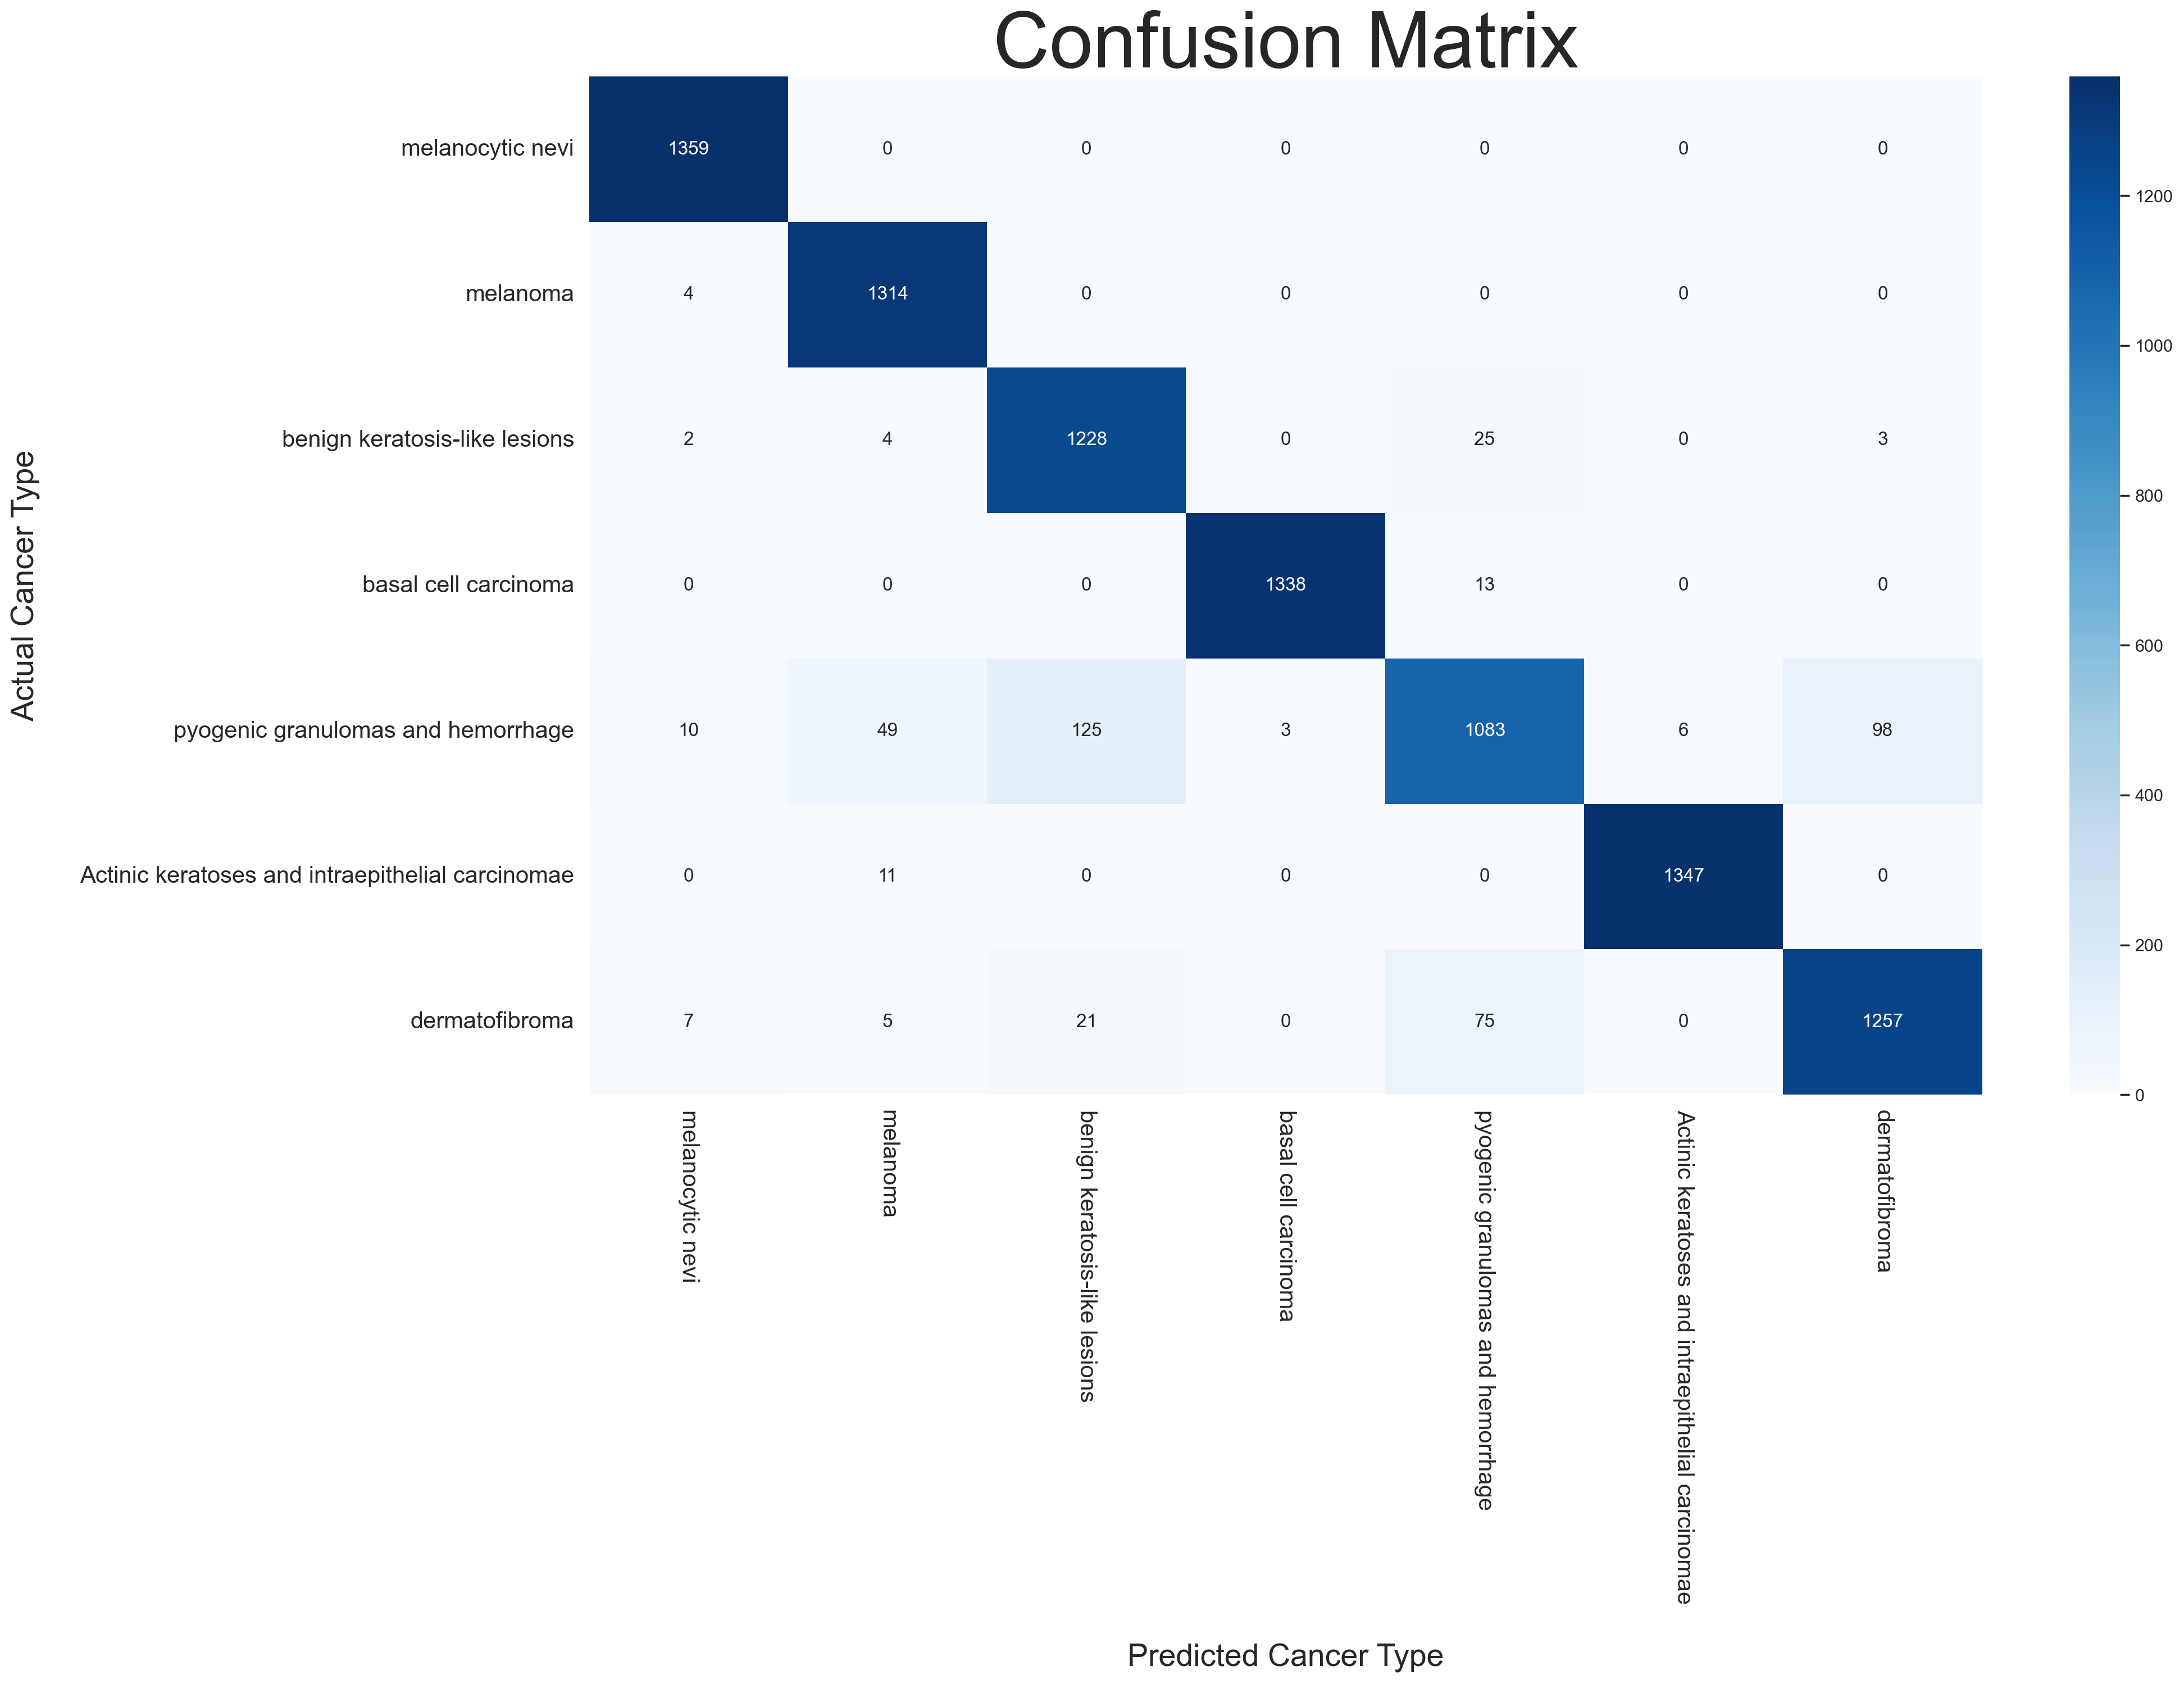

In [160]:
# Plot the Confusion Matrics
plt.figure(figsize=(20,12), dpi=200)
sns.set(font_scale= 1)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix',fontsize=50);
ax.set_xlabel('\nPredicted Cancer Type',fontsize=20)
ax.set_ylabel('Actual Cancer Type\n',fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classesList,fontsize=15, rotation=-90)
ax.yaxis.set_ticklabels(classesList,fontsize=15, rotation=0)
plt.savefig('Confusion_Matrix.png')
## Display the visualization of the Confusion Matrix.
plt.show()

In [53]:
# Name of classes
classesList = [
    'melanocytic nevi',
    'melanoma',
    'benign keratosis-like lesions',
    'basal cell carcinoma',
    'pyogenic granulomas and hemorrhage',
    'Actinic keratoses and intraepithelial carcinomae',
    'dermatofibroma',
    ]
# Print classification report for the model
print(classification_report(Y_test,y_pred, target_names=classesList))

                                                  precision    recall  f1-score   support

                                melanocytic nevi       0.98      1.00      0.99      1359
                                        melanoma       0.95      1.00      0.97      1318
                   benign keratosis-like lesions       0.89      0.97      0.93      1262
                            basal cell carcinoma       1.00      0.99      0.99      1351
              pyogenic granulomas and hemorrhage       0.91      0.79      0.84      1374
Actinic keratoses and intraepithelial carcinomae       1.00      0.99      0.99      1358
                                  dermatofibroma       0.93      0.92      0.92      1365

                                        accuracy                           0.95      9387
                                       macro avg       0.95      0.95      0.95      9387
                                    weighted avg       0.95      0.95      0.95      9387



### Load Model for custom predict (image)

In [6]:
model = tf.keras.models.load_model('HAM_Model.h5')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [2]:
from tensorflow.keras.preprocessing import image as image_utils

image = image_utils.load_img('Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_0024331.jpg', target_size=(28, 28))
image = image_utils.img_to_array(image)
type(image)


numpy.ndarray

In [3]:
x = np.expand_dims(image, axis=0)
x.shape

(1, 28, 28, 3)

In [4]:
x = (x-np.mean(x)) / np.std(x)
x.shape

(1, 28, 28, 3)

In [22]:
classesListOrdered = ['Actinic keratoses and intraepithelial carcinomae',
                      'basal cell carcinoma',
                      'benign keratosis-like lesions',
                      'dermatofibroma', 'melanocytic nevi',
                      'pyogenic granulomas and hemorrhage',
                      'melanoma']

In [10]:
pred = model.predict(x)
print(type(pred))
index = np.argmax(pred)

1/1 [==============================] - 0s 40ms/step
<class 'numpy.ndarray'>


In [28]:
df = pd.DataFrame(classesListOrdered, columns=['class'])
df['precent'] = pred.round(4)[0]*100

In [29]:
df.sort_values(by=['precent'], inplace=True, ascending=False)
df

,class,precent
1,basal cell carcinoma,100.0
0,Actinic keratoses and intraepithelial carcinomae,0.0
2,benign keratosis-like lesions,0.0
3,dermatofibroma,0.0
4,melanocytic nevi,0.0
5,pyogenic granulomas and hemorrhage,0.0
6,melanoma,0.0


In [40]:
result = list(classes.get(index))

In [41]:
result[1]

' basal cell carcinoma'

## EfficientNetv2
Trained on Colab

In [ ]:
# Don't run if you run locally
from google.colab import drive
drive.mount('/content/gdrive')

### Read Data

In [192]:
images_names = os.listdir('Skin-Cancer-MNIST-HAM10000/HAM10000/')

newlist = []
for imagename in images_names:
    newlist.append(str('Skin-Cancer-MNIST-HAM10000/HAM10000/'+imagename))
# Load the meta data and store on dataframe
df = pd.read_csv('Skin-Cancer-MNIST-HAM10000/HAM10000_metadata.csv')

# sort the data frame
df = df.sort_values('image_id').reset_index()
# add new column to the dataframe and store images path/name on it
df['image_path'] = pd.DataFrame(newlist)

# load the image onto dataframe
df.head(10)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
1,4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
2,4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
3,3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
4,1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
5,4497,HAM_0000981,ISIC_0024311,nv,follow_up,75.0,female,back,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
6,700,HAM_0001359,ISIC_0024312,bkl,histo,75.0,male,lower extremity,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
7,2130,HAM_0002869,ISIC_0024313,mel,histo,50.0,female,back,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
8,6803,HAM_0002198,ISIC_0024314,nv,histo,75.0,male,lower extremity,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...
9,1327,HAM_0007538,ISIC_0024315,mel,histo,55.0,male,trunk,Skin-Cancer-MNIST-HAM10000/HAM10000/ISIC_00243...


### Preprocessing

In [193]:
# sort the image_path 
df1 = df['image_path']
df1 = df1.sort_values().reset_index()
df1.columns=['index','image_path']
df['image_path'] = df1['image_path']

In [ ]:
# load the image and resize it onto 300x300
df['image'] = df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((300,300))))

In [195]:
# make image to an array
X = np.asarray(df['image'].tolist())

In [196]:
from sklearn.preprocessing import LabelEncoder
y = df.dx
y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)

In [197]:
# save the target in dict
ycode = y_labelencoder.transform(y_labelencoder.classes_)
yclass = y_labelencoder.classes_
ydict = {}
for key,value in zip(ycode,yclass):
    ydict[key]=value
ydict

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

In [200]:
# one hot encoding 
y = to_categorical(y, num_classes = 7)

### Split Data for Train & Test

In [201]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=1)

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=1)

### Model Building (Transfer-Learning)

In [208]:
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(300, 300, 3))

    model = efficientnet_v2.EfficientNetV2B3(include_top=False, 
                                             weights="imagenet", input_shape=(300,300,3),
                                             input_tensor=inputs
                                            )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [211]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='EfficientNetHAM_Model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [210]:
model = build_model(num_classes=7)
epochs = 20

52606240/52606240 [==============================] - 7s 0us/step


### Training

In [212]:
### Train the model
history = model.fit(X_train,
                    Y_train,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 1.4148 - accuracy: 0.6586
Epoch 1: saving model to EfficientNetHAM_Model.h5
63/63 [==============================] - 87s 1s/step - loss: 1.4148 - accuracy: 0.6586
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.7257
Epoch 2: saving model to EfficientNetHAM_Model.h5
63/63 [==============================] - 59s 932ms/step - loss: 1.0182 - accuracy: 0.7257
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.7385
Epoch 3: saving model to EfficientNetHAM_Model.h5
63/63 [==============================] - 60s 949ms/step - loss: 0.9125 - accuracy: 0.7385
Epoch 4/20
63/63 [==============================] - ETA: 0s - loss: 0.9048 - accuracy: 0.7359
Epoch 4: saving model to EfficientNetHAM_Model.h5
63/63 [==============================] - 60s 950ms/step - loss: 0.9048 - accuracy: 0.7359
Epoch 5/20
63/63 [==============================] - ETA: 0s - loss:

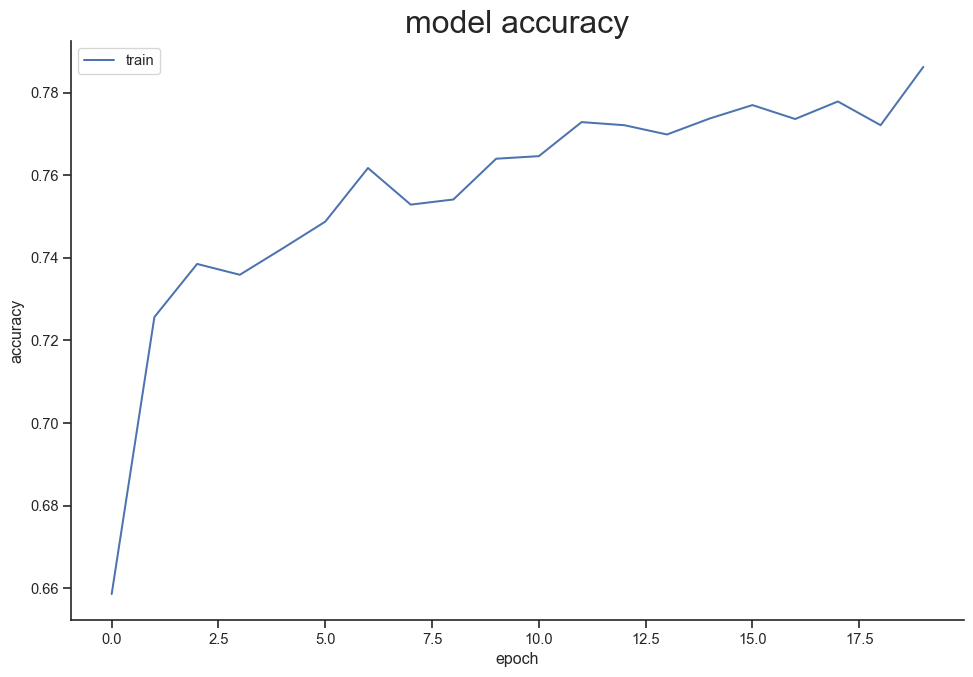

In [218]:
# Plot Model Training and Validation Accuracy during learning period
plt.figure(figsize=(12,8),dpi=96)
plt.plot(history.history['accuracy'])
plt.title('model accuracy', size=24)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

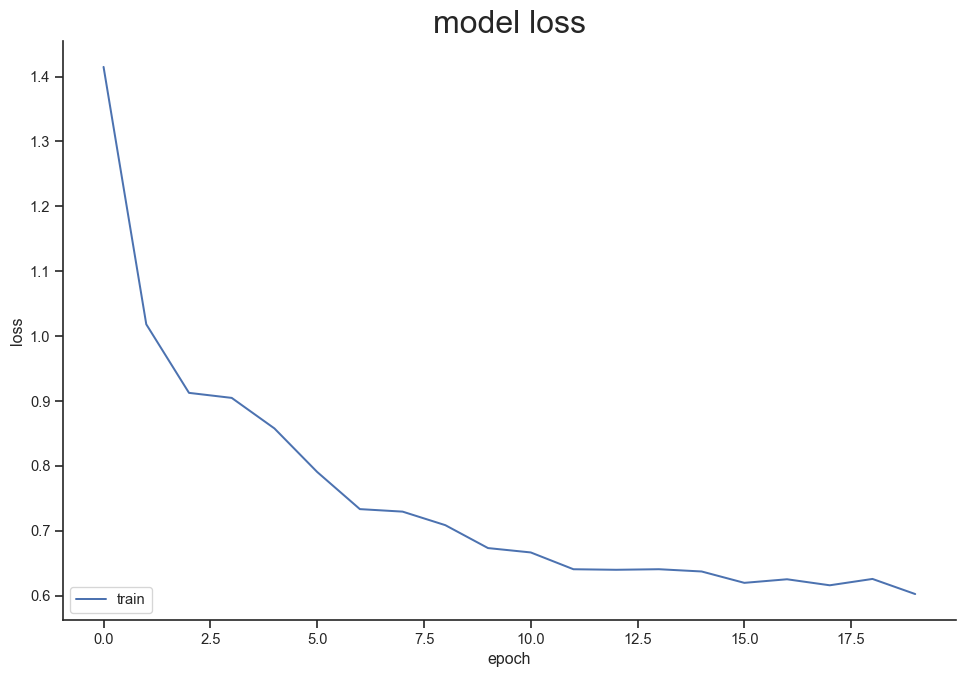

In [219]:
# # Plot Model Training and Validation Loss during learning period
plt.figure(figsize=(12,8),dpi=96)
plt.plot(history.history['loss'])
plt.title('model loss', size=24)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='lower left')
plt.show()

### Fine_Tuning

In [215]:
# Unfreaze some layers on the efficientnet model
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
unfreeze_model(model)

In [ ]:
# Train the model after unfreaze and fine Tuning
hist = model.fit(X_train, Y_train, epochs=10)

In [ ]:
# Save the model onto h5 file
model.save('my_model.h5')

In [226]:
model = tf.keras.models.load_model('my_model.h5', compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [227]:
# Test the model X_test,Y_test and print the loss and accuracy
# Testing 20% of the dataset (around 2k recoreds)

score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

63/63 [==============================] - 19s 232ms/step - loss: 0.4704 - accuracy: 0.8422
Test loss: 0.47036904096603394
Test accuracy: 0.8422366380691528


In [228]:
# prediction on test data 
Y_pred = model.predict(X_test)

63/63 [==============================] - 16s 215ms/step


In [229]:
# Returns the indices of the maximum values along an axis.
y_pred = np.argmax(Y_pred, axis=1)

In [233]:
Y_test = np.argmax(Y_test, axis=1)

In [234]:
# Generate Confusion Matrix
cf_matrix = confusion_matrix(Y_test, y_pred)

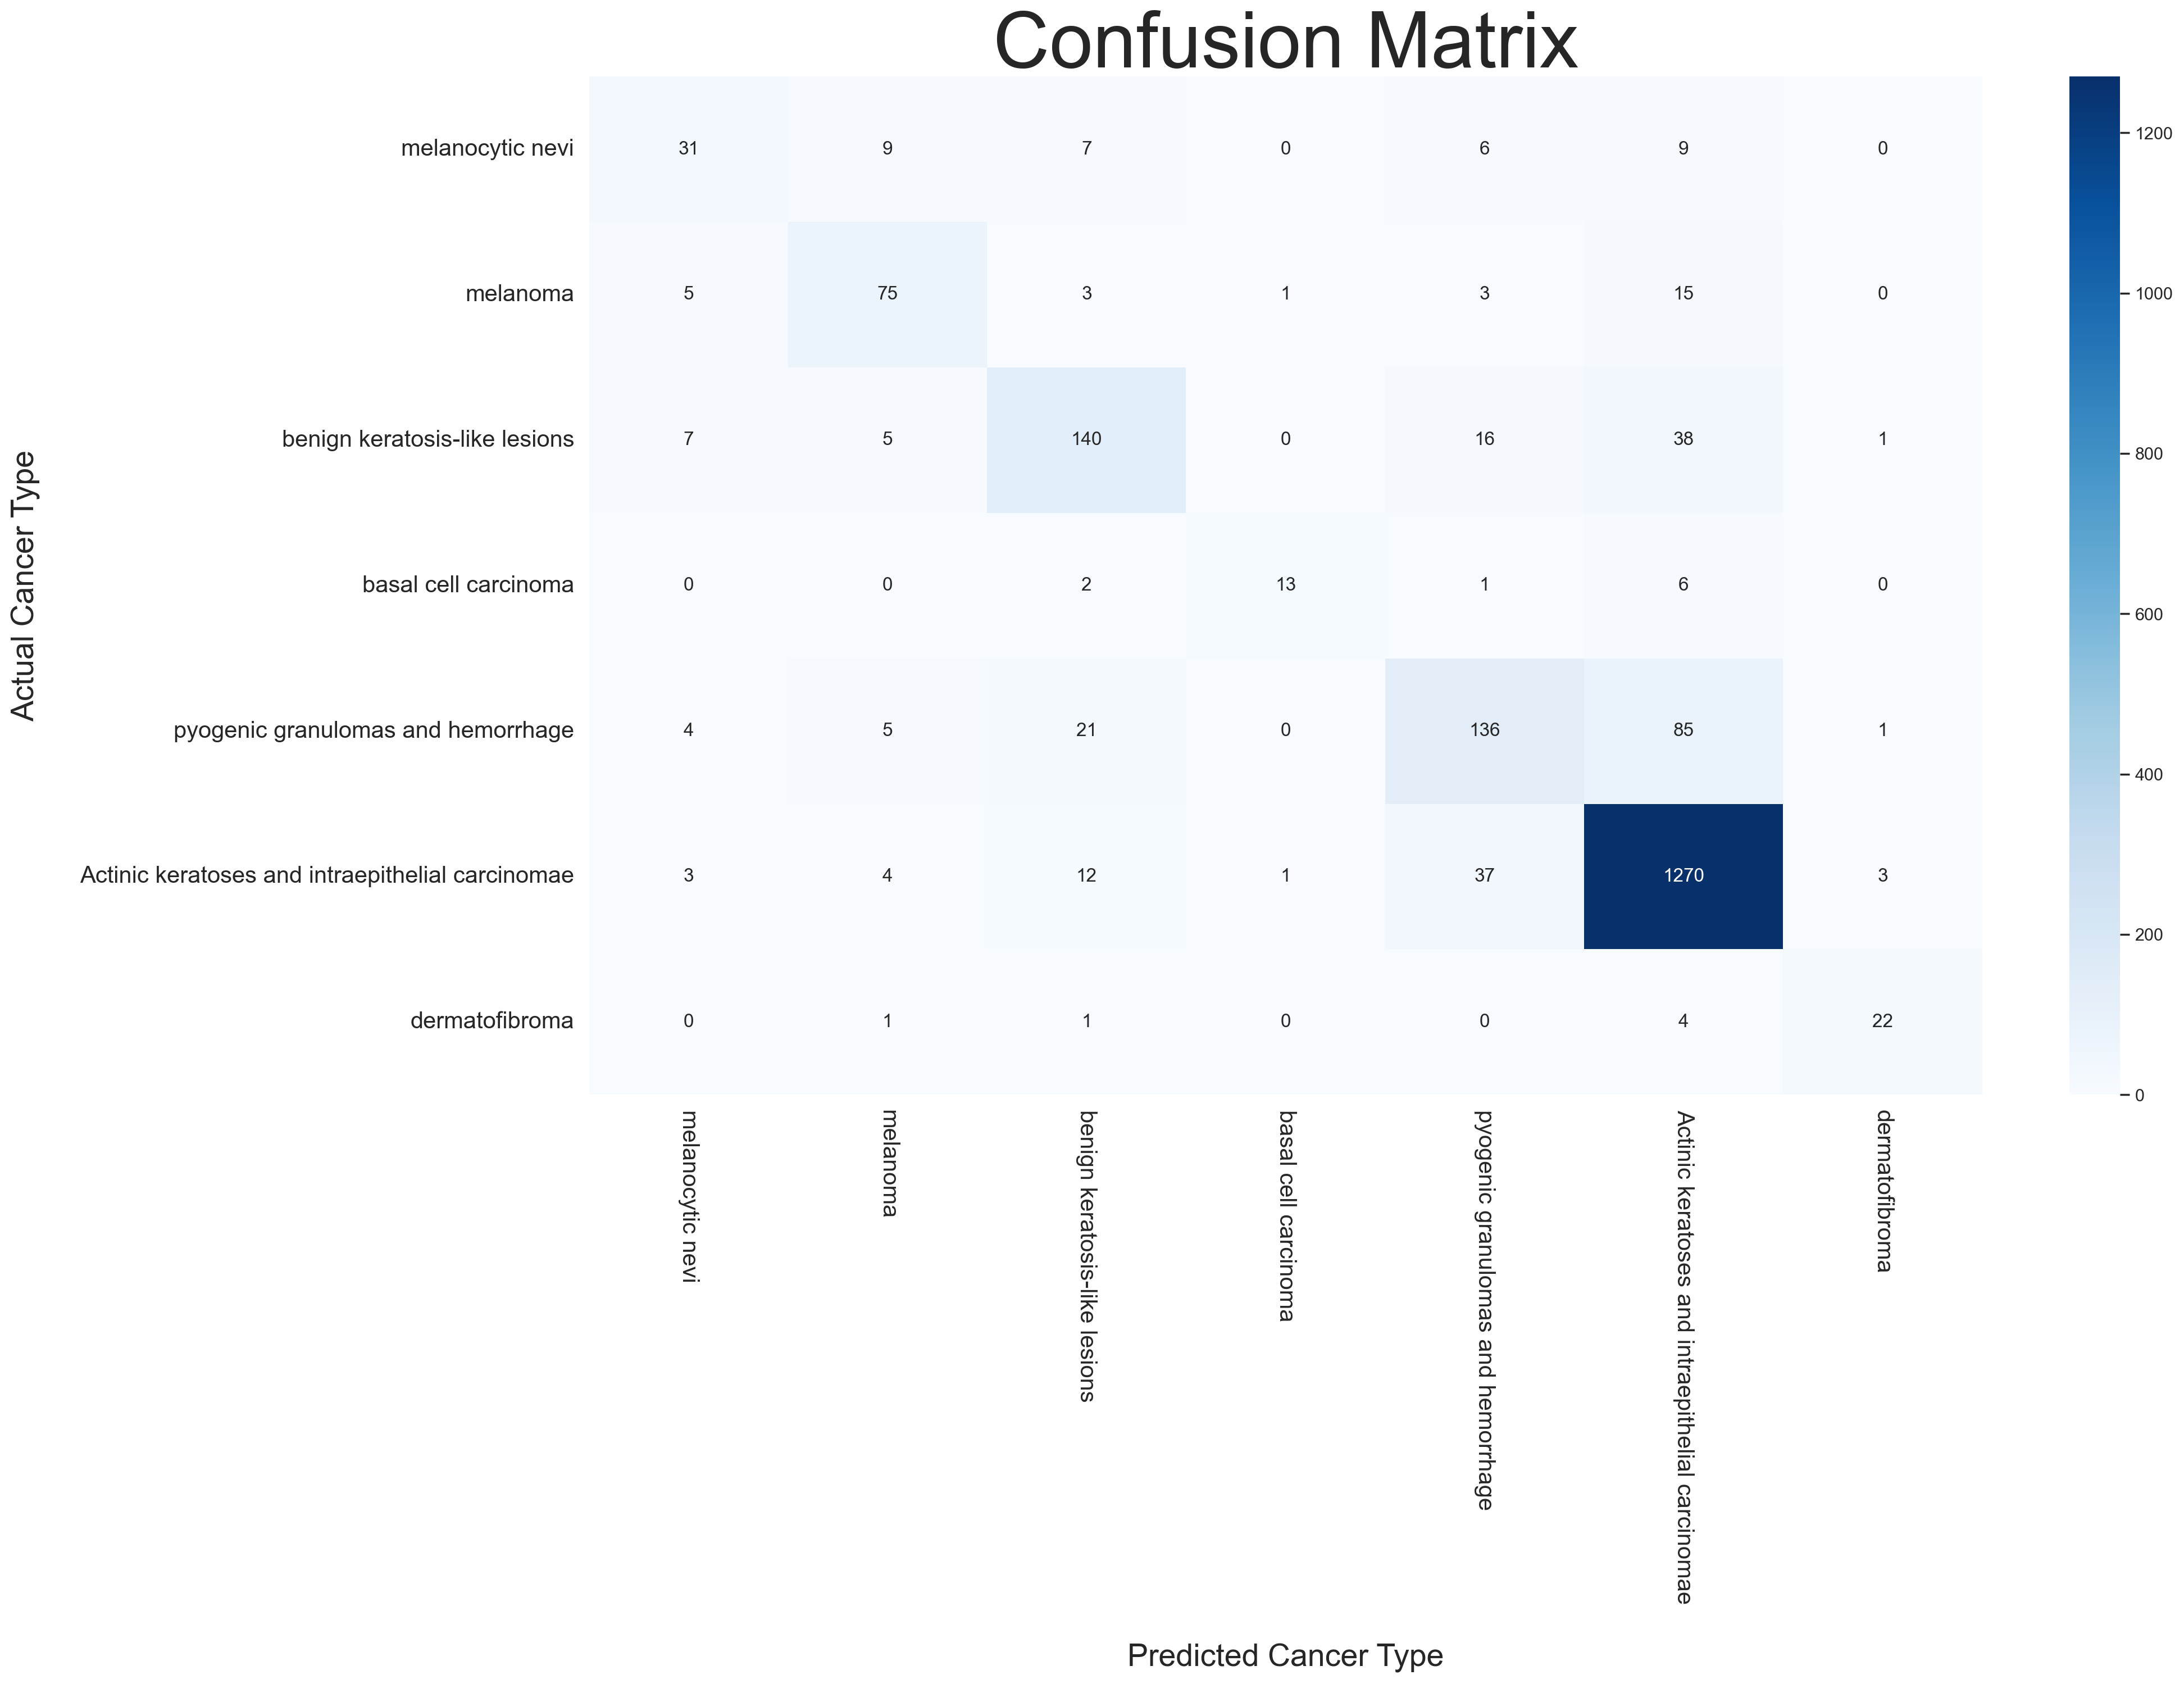

In [235]:
# Plot the Confusion Matrics
plt.figure(figsize=(20,12), dpi=200)
sns.set(font_scale= 1)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix',fontsize=50);
ax.set_xlabel('\nPredicted Cancer Type',fontsize=20)
ax.set_ylabel('Actual Cancer Type\n',fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classesList,fontsize=15, rotation=-90)
ax.yaxis.set_ticklabels(classesList,fontsize=15, rotation=0)
plt.savefig('Confusion_Matrix.png')
## Display the visualization of the Confusion Matrix.
plt.show()

In [236]:
print(classification_report(Y_test,y_pred, target_names=classesList))

                                                  precision    recall  f1-score   support

                                melanocytic nevi       0.62      0.50      0.55        62
                                        melanoma       0.76      0.74      0.75       102
                   benign keratosis-like lesions       0.75      0.68      0.71       207
                            basal cell carcinoma       0.87      0.59      0.70        22
              pyogenic granulomas and hemorrhage       0.68      0.54      0.60       252
Actinic keratoses and intraepithelial carcinomae       0.89      0.95      0.92      1330
                                  dermatofibroma       0.81      0.79      0.80        28

                                        accuracy                           0.84      2003
                                       macro avg       0.77      0.68      0.72      2003
                                    weighted avg       0.83      0.84      0.84      2003

